In [42]:
import matplotlib.pyplot as plt

from desc.continuation import solve_continuation_automatic
from desc.backend import jnp, functools, jit
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid, QuadratureGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    EffectiveRadius,
    ParallelConnectionLength,
    QuasisymmetryTwoTerm,
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_comparison,
    plot_section,
    plot_surfaces,
    plot_boundaries,
    plot_boozer_surface,
    plot_boozer_surface,
    plot_boundary,
)

## Methods ##

In [2]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


# Function to get the straight field line coordinate system, need iota for jit
# @functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq, iota, rho=0.5, alpha=0, n_pol=4, n_points=200):
    n_tor = n_pol / (iota * eq.NFP)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0, 2 * n_tor * jnp.pi, n_points * n_pol),
        coordinates="raz",
        iota=iota,
        period=(jnp.inf, 2 * jnp.pi, jnp.inf),
    )
    return good_grid

In [17]:
def run_step(k, eq, maxiter=3, method="proximal-lsq-exact", target_type="all"):
    """Run a step of the precise QH optimization example from Landreman & Paul."""

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    # grid = get_field_line_grid(eq,n_pol=10)

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            # EffectiveRadius(eq=eq,grid=grid, target_type=target_type, target=jnp.ones(7)),
            # EffectiveRadius(eq=eq,n_wells=4,target_type=target_type,n_pol=10,target=1.7*jnp.ones(4)),
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, 0), grid=grid),
            EffectiveRadius(eq=eq, n_wells=5, target_type=target_type, n_pol=11),
            # ParallelConnectionLength(eq=eq,n_wells=4,target_type=target_type,n_pol=10,target=2*jnp.ones(4)),
            # ForceBalance(eq=eq),
            # ParallelConnectionLength(eq=eq,grid=grid),
            # BallooningStability(eq=eq),
            # try to keep the aspect ratio about the same
            # AspectRatio(eq=eq, target=8, weight=100),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                jnp.max(jnp.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer(method)

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=maxiter,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        # xtol=1e-3,
        # gtol=1e-3,
        # ftol = 1e-8,
        # ctol = 1e-3,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

In [4]:
def plot_Kd(eq, n_pol=16, rho=0.5, n_wells=5):
    iota_grid = LinearGrid(rho=rho)
    iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
    Kd = get_value(eq, "Kd", grid)
    plt.figure()
    plt.plot(grid.nodes[:, 2], Kd)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
    L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
    a = get_value(eq, "a", grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
        f"Mean value of $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
        f"Minimum value of $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
        f"Minimum value of $a/L_{{par}}$: {a/L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    plt.text(
        0.05,
        0.95,
        textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    # print(f"Values of R_eff are: {R_eff}")
    # print(f"Values of L_par are: {L_par}")
    return grid, R_eff, L_par

In [5]:
def compare_optimizations(eq, mode_lim=1):
    eqfam = EquilibriaFamily(eq)
    iota_grid = LinearGrid(rho=0.5)
    iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq, iota, n_pol=16)
    eq1 = run_step(mode_lim, eq, grid, target_type="mean")
    eq2 = run_step(mode_lim, eq, grid, target_type="max")
    eqfam.append(eq1)
    eqfam.append(eq2)
    plot_Kd(eq)
    plot_Kd(eq1)
    plot_Kd(eq2)
    return eqfam

In [6]:
def check_force_error(eq):
    grid = QuadratureGrid(eq.L_grid, eq.M_grid, eq.N_grid, eq.NFP)
    data = eq.compute(["p", "sqrt(g)", "|F|", "|grad(|B|^2)|/2mu0"], grid)
    err = jnp.sum(data["|F|"] * data["sqrt(g)"] * grid.weights) / jnp.sum(
        data["|grad(|B|^2)|/2mu0"] * data["sqrt(g)"] * grid.weights
    )
    print("eq error: {:.2f}%".format(err * 1e2))

## Testing ##

In [34]:
eq = get("HSX")

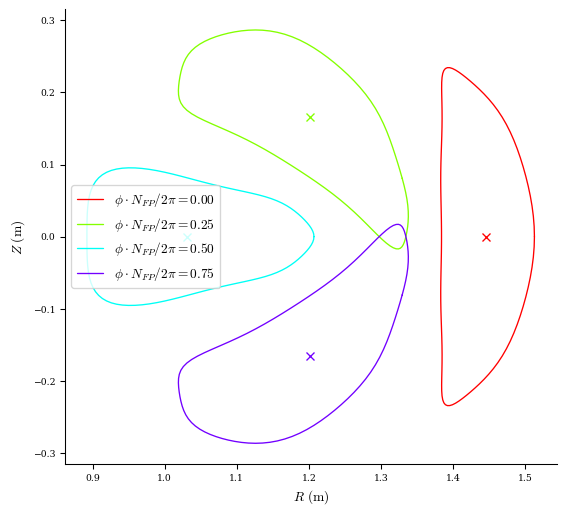

In [43]:
plot_boundary(eq);

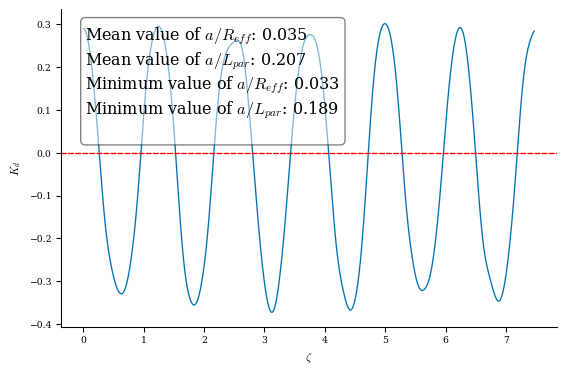

In [46]:
grid, R_eff, L_par = plot_Kd(eq, n_pol=5);

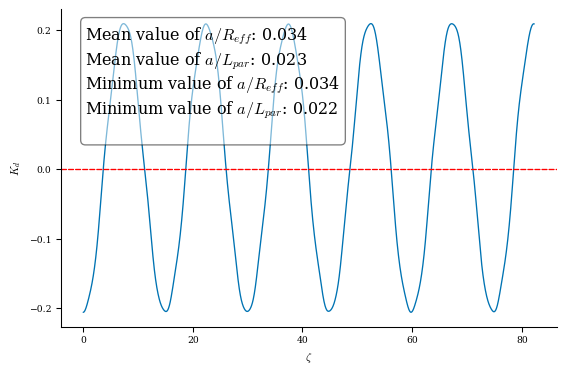

In [18]:
grid, R_eff, L_par = plot_Kd(eq, n_pol=11, n_wells=5)

In [19]:
print(f"R_eff : {R_eff}")
print(f"L_par : {L_par}")

R_eff : [4.94659012 4.99558832 4.95446845 4.91170025 4.93471454]
L_par : [7.70731601 7.55765939 7.48283108 7.44541693 7.2957603 ]


In [11]:
iota_grid = LinearGrid(
    rho=0.5,
    M=eq.M_grid,
    N=eq.N_grid,
    NFP=eq.NFP,
)
iota = eq.compute("iota", grid=iota_grid)["iota"]
print(iota[0])

-1.0519588800791597


In [12]:
iota_grid2 = LinearGrid(
    rho=0.5,
)
iota2 = eq.compute("iota", grid=iota_grid2)["iota"]
print(iota2[0])

-1.0519588800791597


In [20]:
eq_test = eq.copy()

In [21]:
eq2 = run_step(1, eq_test, maxiter=3)

/tmp/ipykernel_539331/3453678775.py:32: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 1.01 sec
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 369 us
Timer: Objective build = 1.59 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.03 sec
Timer: Objective build = 2.11 sec
Timer: Proximal projection build = 8.23 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 538 ms
Timer: Linear constraint projection build = 1.76 sec
Number of parameters: 8
Number of objectives: 1688
Timer: Initializing the optimization = 10.6 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.507e+01                                    2.737e+02   
       1              

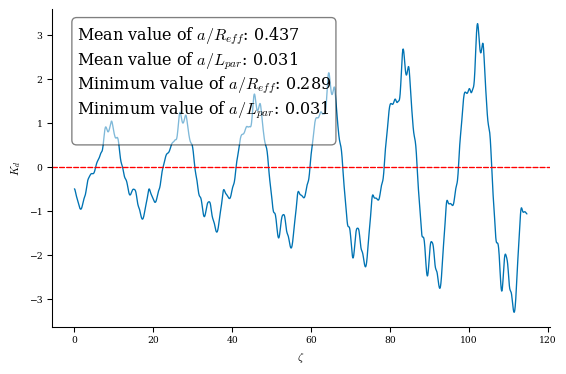

In [22]:
_, R_eff2, L_par2 = plot_Kd(eq2, n_pol=12);

In [23]:
print(f"R_eff : {R_eff2}")
print(f"L_par : {L_par2}")

R_eff : [1.13592443 0.8954564  0.69774687 0.55949668 0.46227055]
L_par : [10.5184815  10.47067022 10.47067022 10.47067022 10.2794251 ]


In [85]:
eq_test = eq.copy()

In [87]:
eq3 = run_step(1, eq_test, maxiter=10)

/tmp/ipykernel_391879/812124138.py:25: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 441 us
Timer: Objective build = 90.4 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 52.8 ms
Timer: Objective build = 69.9 ms
Timer: Proximal projection build = 770 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 115 ms
Timer: Linear constraint projection build = 114 ms
Number of parameters: 8
Number of objectives: 4
Timer: Initializing the optimization = 1.03 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.147e+00                                    6.589e+01   
       1              2          4.639e-03      1.142e+00      7.893e-02      1.212e+00   
       2              7          4.520e

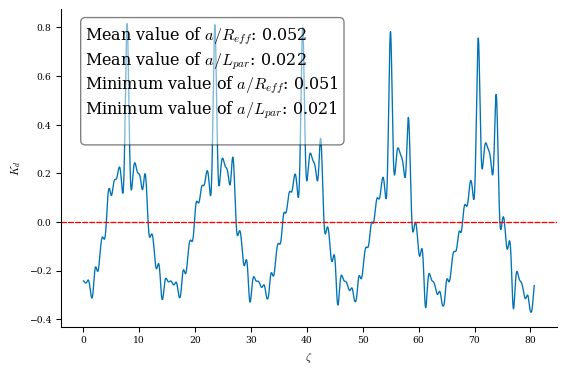

In [95]:
_, R_eff3, L_par3 = plot_Kd(eq3, n_pol=10, n_wells=3);

In [96]:
print(f"R_eff : {R_eff3}")
print(f"L_par : {L_par3}")

R_eff : [3.57118337 3.5281477  3.45307047]
L_par : [8.87936252 8.35467291 8.31431218]


In [103]:
eq_test = eq.copy()

In [107]:
eq4 = run_step(1, eq_test, maxiter=5)

/tmp/ipykernel_391879/505397156.py:31: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 581 us
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 1.00 sec
Timer: Objective build = 1.16 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 58.7 ms
Timer: Objective build = 74.2 ms
Timer: Proximal projection build = 1.88 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 116 ms
Timer: Linear constraint projection build = 113 ms
Number of parameters: 8
Number of objectives: 1687
Timer: Initializing the optimization = 2.13 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.628e+01                                    5.937e+02   
       1              2   

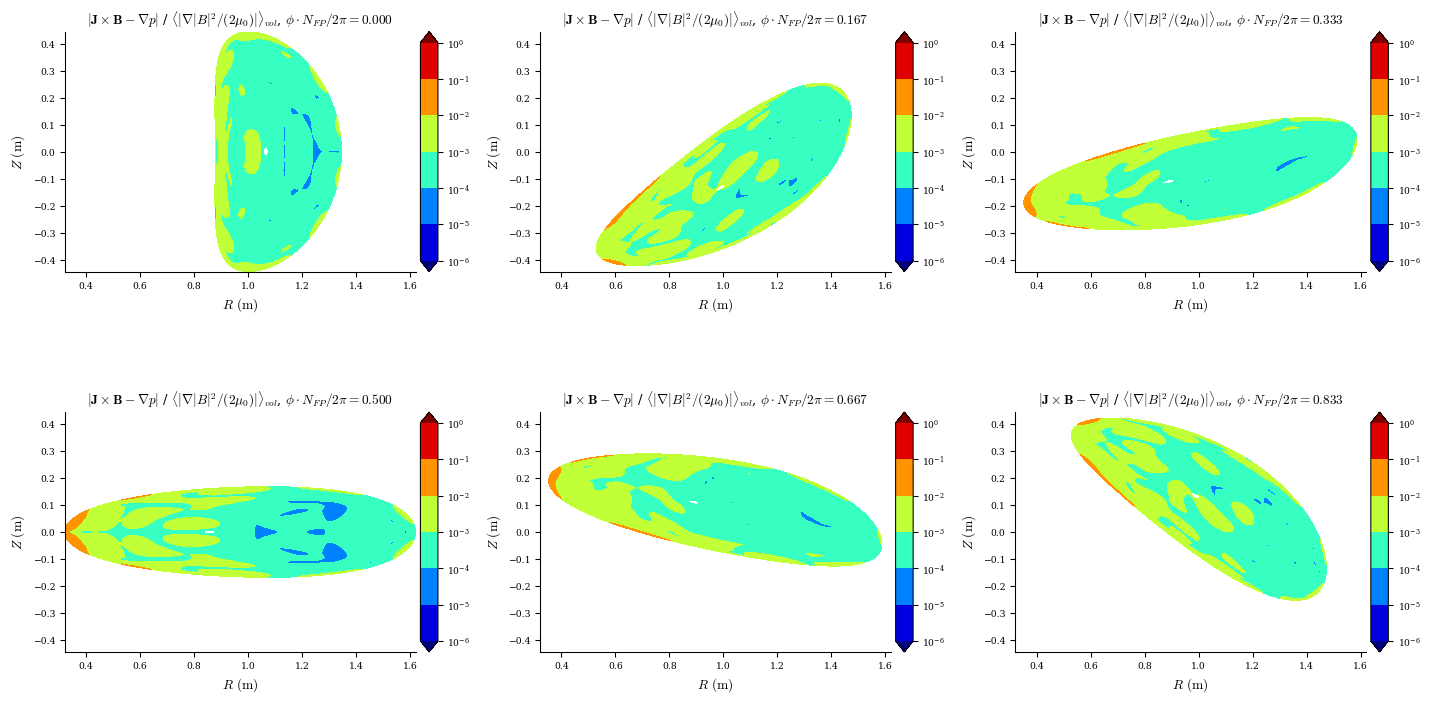

In [24]:
plot_section(eq2, "|F|", norm_F=True, log=True);

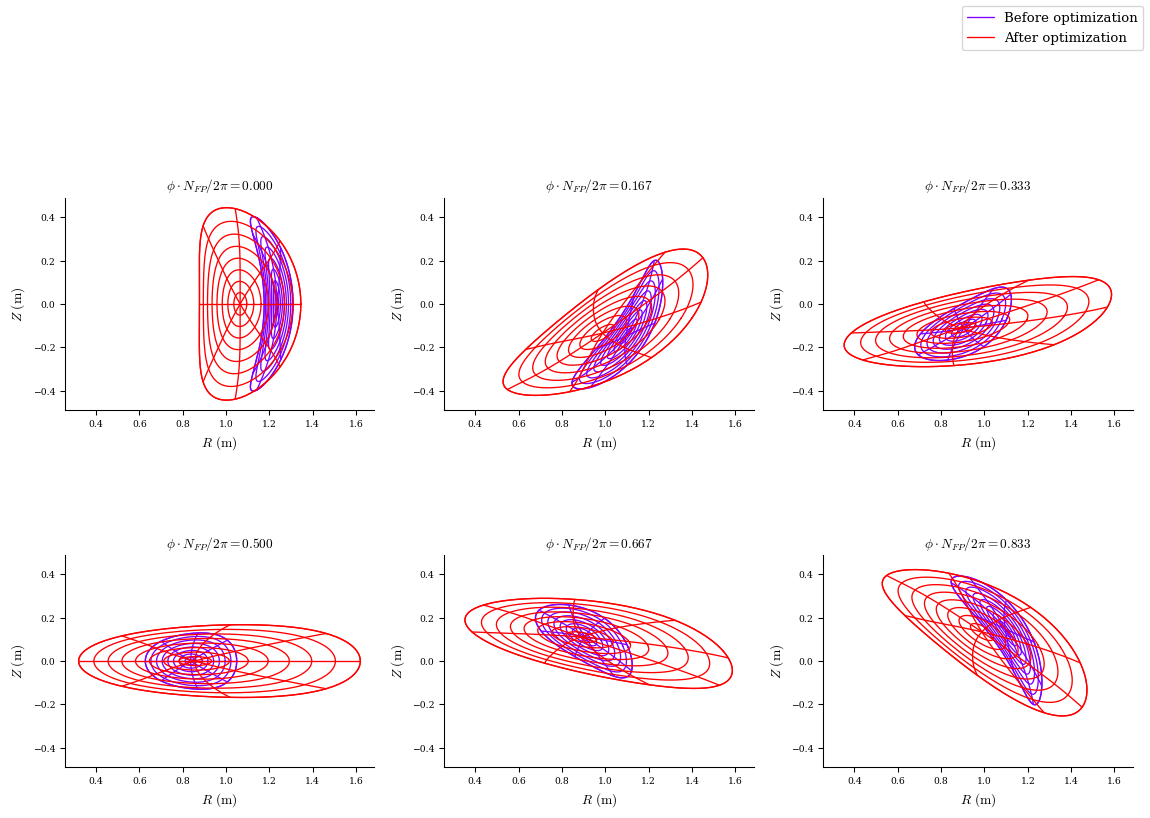

In [25]:
fig, ax = plot_comparison(
    eqs=[eq, eq2],
    labels=[
        "Before optimization",
        "After optimization",
    ],
)

In [26]:
err = check_force_error(eq2)

eq error: 0.08%


(<Figure size 576x576 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

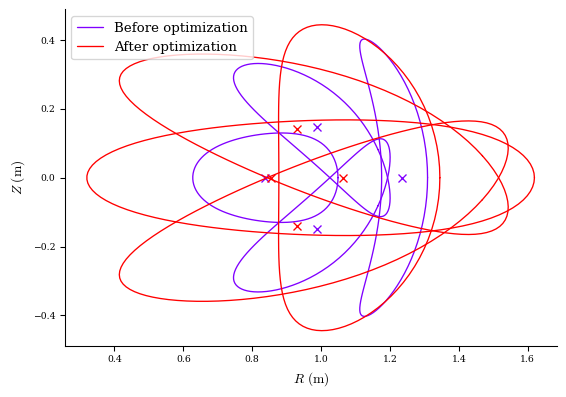

In [27]:
plot_boundaries(
    eqs=[eq, eq2],
    labels=[
        "Before optimization",
        "After optimization",
    ],
)

(<Figure size 576x576 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

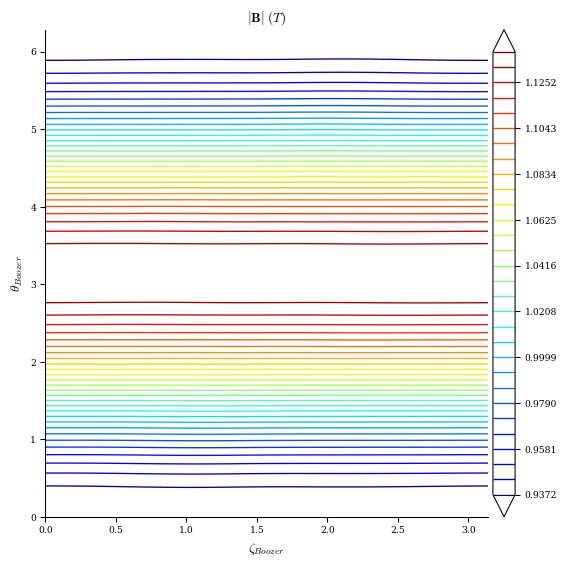

In [28]:
plot_boozer_surface(eq)

(<Figure size 576x576 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

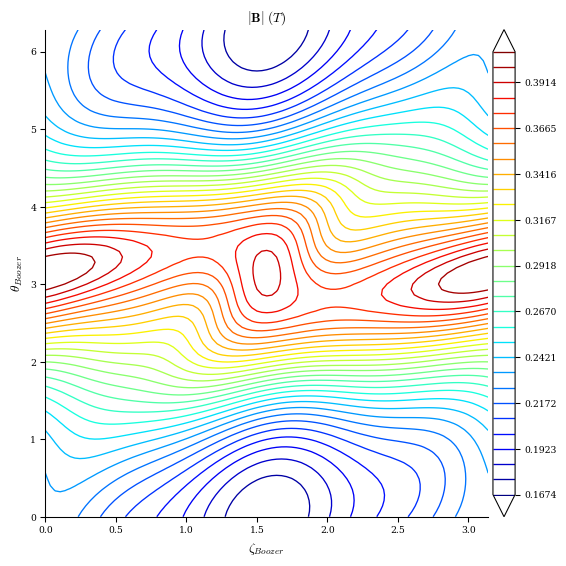

In [33]:
plot_boozer_surface(eq2, rho=0.9)

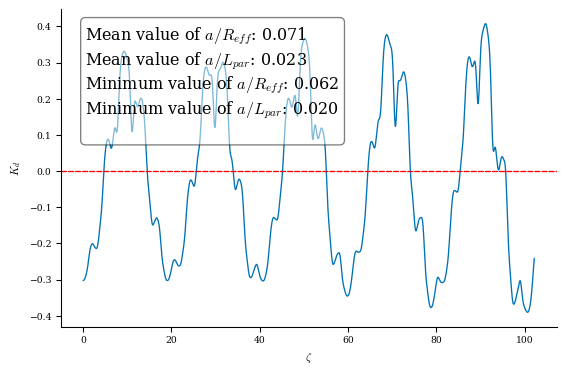

(Grid at 0x7f645fabba70 (L=2000, M=2000, N=2000, NFP=1, sym=False, is_meshgrid=False, node_pattern=custom, coordinates=rtz),
 Array([3.6822977 , 3.53709772, 3.20492513, 3.0715365 , 2.6562307 ],      dtype=float64),
 Array([11.29812929, 11.19588378, 11.14476102,  9.40658728,  6.54371289],      dtype=float64))

In [118]:
plot_Kd(eq4, n_pol=10)

(<Figure size 576x576 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

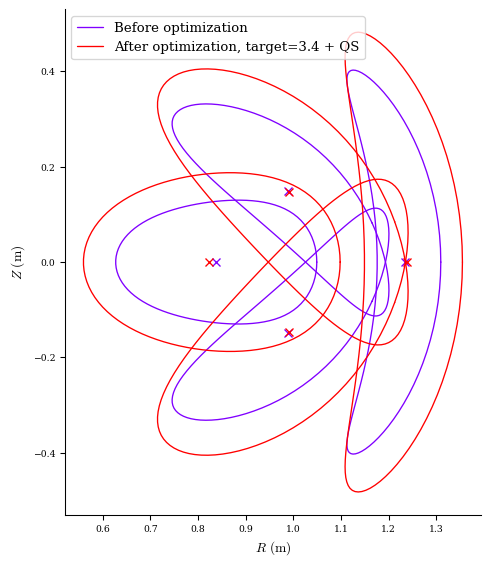

In [121]:
plot_boundaries(
    eqs=[eq, eq4],
    labels=["Before optimization", "After optimization, target=3.4 + QS"],
)